# Whisky Advocate
## *Insights from Reviews*

What makes a great whiskey? It is a smoky flavor? It is peaty? Is it something else?

There isn't a single truth of a great whisky, because tastes vary so much from person to person. However, we can analyze the reviews of experts to see if we can detect patterns in the flavor profiles of 'great' whiskys.

Today, you'll see the following things operationalized in python to study great whiskys:
* [Web Scraping](#web)
* [Data Exploration](#explore)
* [Machine Learning](#ml)
* [Data Visualization](#viz)


<a id="web"></a>
## Web Scraping
To gather our review data to understand great whiskeys, we will *scrape* [Whisky Advocate's](http://whiskeyadvocate.com) over 4,00 reviews. We will use python to access the reviews on the web and extract the relevant information from directly from the site's `html`.

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [2]:
score_range = ['95-100', '90-94', '80-89', '70-79', '60-69']

In [3]:
url = "http://whiskyadvocate.com/ratings-reviews/?search=&submit=&brand_id=0&rating={}&price=0&category=0&styles_id=0&issue_id=0"

In [4]:
urls = [url.format(score) for score in score_range]

In [5]:
tags = ['ratingValue', 'name', 'category', 'priceCurrency', 
 'price', 'description', 'author']

def get_review(review):
    data = {}
    for t in tags:
        data[t] = review.find(itemprop=t).text

    return data

def whiskey(urls):
    
    whiskey_reviews = list()
    
    for u in urls:
        r = requests.get(u)
        
        soup = BeautifulSoup(r.text, "lxml")
        ratings = soup.find(class_="ratings-grid-holder")
        
        ratings = ratings.find_all("article")
        
        reviews = [get_review(r) for r in ratings]
        
        whiskey_reviews += reviews
    
    return whiskey_reviews

In [6]:
data = whiskey(urls)

In [7]:
data[42]

{'author': 'John Hansell',
 'category': 'Single Malt Scotch',
 'description': '\nThe Dalmore is one of a handful of whiskies that seem to be able to age in the cask for many decades and still improve. This one is incredibly viscous on the nose and palate (and very heavy on the tongue), with chewy toffee and old pot still rum. The classic Dalmore marmalade note shines throughout, along with vanilla cream, an array of dried spices (especially cinnamon and evergreen), juicy oak, forest bedding, rancio, old armagnac, polished leather, tobacco, maple syrup, dark chocolate, almond macaroon, and subtle espresso. Long, mouth-coating finish. The flavors evolve like waves lapping on the palate -- especially the interplay with the oak. I can’t drink this whisky slowly enough. A rare experience for the lucky few who can afford it. (Price is per 100ml.)',
 'name': 'The Dalmore 50 year old, 52.8%',
 'price': '1,500',
 'priceCurrency': '$',
 'ratingValue': '96'}

<a id="explore"></a>
## Data Exploration

In [8]:
df = pd.DataFrame.from_records(data)

In [9]:
df.head()

,ratingValue,name,category,priceCurrency,price,description,author
0,97,Midleton Very Rare Silent Distillery Chapter 2...,Irish Single Pot Still,$,"45,000",\n\nGive this an hour to unfurl; the nose reve...,Jonny McCormick
1,97,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,$,225,\nMagnificently powerful and intense. Caramels...,Jonny McCormick
2,97,Four Roses Limited Edition Small Batch (2013 R...,Bourbon/Tennessee,$,85,\nA marriage of 13 and 18 year old bourbons. A...,John Hansell
3,97,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,$,13500,\nThere have been some legendary Bowmores from...,Dave Broom
4,97,"Parker's Heritage Collection, 'Golden Annivers...",Bourbon/Tennessee,$,150.00,\nThis bottling celebrates master distiller Pa...,John Hansell


In [10]:
df.shape[0]

6042

In [11]:
df['ratingValue'].astype('int').describe()

count    6042.000000
mean       87.408805
std         4.462655
min        60.000000
25%        85.000000
50%        88.000000
75%        91.000000
max        97.000000
Name: ratingValue, dtype: float64

In [12]:
df['category'].value_counts()

Single Malt Scotch                  2217
Bourbon/Tennessee                   1035
Rye Whiskey                          379
Blended Scotch Whisky                296
Canadian                             276
Blended Malt Scotch Whisky           194
American Whiskey                     151
Japanese Whisky                      131
Single Malt American Whiskey         120
Blended Irish Whiskey                119
Single Grain Scotch                  108
Irish                                108
Irish Single Malt                     79
Flavored Whisky & Liqueurs            66
Indian Whisky                         54
Irish Single Pot Still                53
French Whisky                         51
Single Malt Swedish Whisky            50
Australian Whisky                     46
World Whisky                          45
White Whiskey                         44
Blended American Whiskey              35
Single Malt English Whisky            34
Wheat Whiskey                         32
Taiwanese Whisky

In [13]:
df['price'].head()

0    45,000
1       225
2        85
3     13500
4    150.00
Name: price, dtype: object

In [14]:
df['p2'] = df['price'].astype('str').replace(",","").replace("$", "")

In [15]:
df['p2'].head()

0    45,000
1       225
2        85
3     13500
4    150.00
Name: p2, dtype: object

In [16]:
df['p2'].str.replace("$", "").str.replace("/set","").astype('str')

0       45,000
1          225
2           85
3        13500
4       150.00
         ...  
6037        17
6038        35
6039     60.00
6040        50
6041        30
Name: p2, Length: 6042, dtype: object

In [17]:
df['p2'] = pd.to_numeric(df['p2'], errors='coerce')

In [18]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')

In [19]:
df['price'].sort_values( ascending=False)

523     157000.0
103      26650.0
1333     23427.0
3251     14999.0
3        13500.0
          ...   
5723         NaN
5804         NaN
5900         NaN
5939         NaN
5993         NaN
Name: price, Length: 6042, dtype: float64

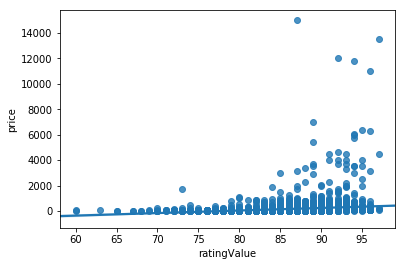

In [ ]:
import seaborn as sns
from locale import atof

#df['price'] = df['price'].apply(atof)
sns.regplot(x=df[df['price'] < 20000]['ratingValue'].astype('float'), y=df[df['price'] < 20000]['price'])

In [20]:
df['pert_alcohol'] = df['name'].apply(lambda x: x.split()[-1][:-1])

In [21]:
df['pert_alcohol'].head()

0    53.6
1      40
2    51.5
3    42.9
4      50
Name: pert_alcohol, dtype: object

In [22]:
df['pert_alcohol'] = pd.to_numeric(df['pert_alcohol'], errors='coerce')

In [23]:
df['pert_alcohol'].head()

0    53.6
1    40.0
2    51.5
3    42.9
4    50.0
Name: pert_alcohol, dtype: float64

In [24]:
def  is_it_perct(name):
    #print(name)
    last_seg = name.split()[-1]
    if last_seg[-1:] == "%":
        return last_seg[:-1]
    else:
        return None

In [25]:
df.loc[df['name'].isnull(), 'name'] = 'Bunnahabhain'

In [26]:
df['pert_alcohol'] = df['name'].apply(is_it_perct)
df['pert_alcohol'] = pd.to_numeric(df['pert_alcohol'], errors='coerce')

In [27]:
df['pert_alcohol'].head()

0    53.6
1    40.0
2    51.5
3    42.9
4    50.0
Name: pert_alcohol, dtype: float64

In [28]:
df.head()

,ratingValue,name,category,priceCurrency,price,description,author,p2,pert_alcohol
0,97,Midleton Very Rare Silent Distillery Chapter 2...,Irish Single Pot Still,$,NaN,\n\nGive this an hour to unfurl; the nose reve...,Jonny McCormick,NaN,53.6
1,97,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,$,225.0,\nMagnificently powerful and intense. Caramels...,Jonny McCormick,225.0,40.0
2,97,Four Roses Limited Edition Small Batch (2013 R...,Bourbon/Tennessee,$,85.0,\nA marriage of 13 and 18 year old bourbons. A...,John Hansell,85.0,51.5
3,97,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,$,13500.0,\nThere have been some legendary Bowmores from...,Dave Broom,13500.0,42.9
4,97,"Parker's Heritage Collection, 'Golden Annivers...",Bourbon/Tennessee,$,150.0,\nThis bottling celebrates master distiller Pa...,John Hansell,150.0,50.0


In [29]:
df['pert_alcohol'].describe()

count    5975.000000
mean       47.811698
std         6.434841
min        17.000000
25%        43.000000
50%        46.000000
75%        51.000000
max        79.900000
Name: pert_alcohol, dtype: float64

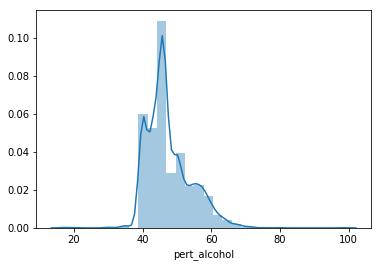

In [ ]:
import seaborn as sns
sns.distplot(df[-df['pert_alcohol'].isnull()]['pert_alcohol'], bins=30)

In [30]:
import numpy as np
df['ratingValueLn'] = np.log(df['ratingValue'].astype('float'))

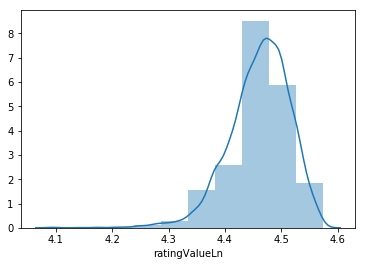

In [ ]:
sns.distplot(df['ratingValueLn'].astype('float'), bins=10)

In [31]:
from sklearn.preprocessing import MaxAbsScaler

In [32]:
scaler = MaxAbsScaler()

In [33]:
x = df['ratingValue'].values

In [34]:
x =x.reshape(-1, 1)

In [35]:
df['ratingValueScaled'] = scaler.fit_transform(x)

In [36]:
df['ratingValueScaled'] = df['ratingValueScaled']

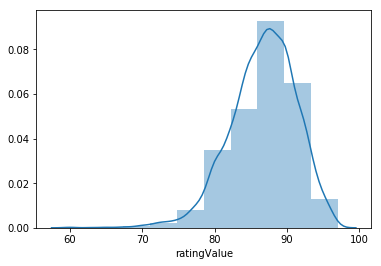

In [ ]:
sns.distplot(df['ratingValue'].astype('float'), bins=10)

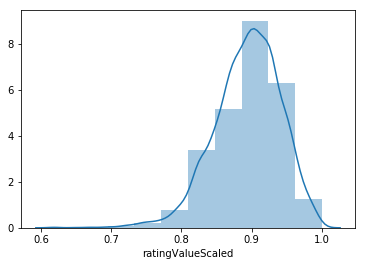

In [ ]:
sns.distplot(df['ratingValueScaled'].astype('float'), bins=10)

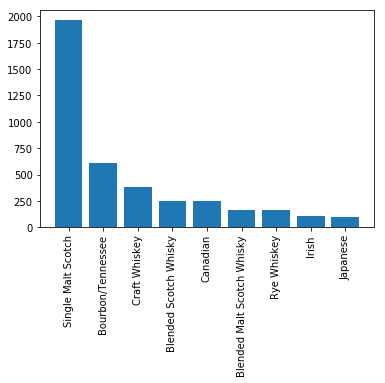

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

types = df['category'].value_counts()[:9]

height = types.tolist()
bars = types.index.tolist()
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)
plt.xticks(y_pos, bars, rotation='vertical')

plt.show()

In [37]:
list(df)

['ratingValue',
 'name',
 'category',
 'priceCurrency',
 'price',
 'description',
 'author',
 'p2',
 'pert_alcohol',
 'ratingValueLn',
 'ratingValueScaled']

In [38]:
#df.to_csv('whiskey_reviews.csv')

<a id="ml"></a>
## Machine Learning
* Can we use the words of the reviews to predict a whisky's review score? 
* Which words are the most important / indicate a good review? 

We'll be applying linear regression to help us answer these questions. To process the text, we'll be using a text vectorization method: Tf-idf (Term Frequency - Inverse Document Frequency).

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
vect = TfidfVectorizer(stop_words='english', max_features=1000, 
                       min_df=5, max_df=.8, ngram_range=(1,2))
X = vect.fit_transform(df['description'])

In [41]:
X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
vect.get_feature_names()[60:80]

['aroma',
 'aromas',
 'aromatic',
 'array',
 'ash',
 'ashy',
 'available',
 'away',
 'background',
 'baked',
 'baked apple',
 'baking',
 'baking spice',
 'baking spices',
 'balance',
 'balanced',
 'banana',
 'bananas',
 'barley',
 'barley sugar']

In [43]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X, df['ratingValue'].astype('float'))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [44]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = reg.predict(X)
print(r2_score(df['ratingValue'].astype('float'), y_pred))

0.573566547757694


In [45]:
model = pd.DataFrame(reg.coef_, columns=['coef'], index=vect.get_feature_names())

In [46]:
y = df['ratingValue'].astype('float').tolist()

In [47]:
from scipy import stats
params = np.append(reg.intercept_,reg.coef_)
predictions = y_pred
newX = pd.DataFrame({"Constant":np.ones(len(X.todense()))}).join(pd.DataFrame(X.todense()))
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X),1)), X, axis=1)
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


In [48]:
model["Std Error"], model["t values"], model['p values'] = [sd_b[1:], ts_b[1:], p_values[1:]]

In [49]:
model.sort_values(by=[ 'coef', 'p values'])

,coef,Std Error,t values,p values
caol ila,-18.251826,15.031,-1.214,0.225
age statement,-18.144989,6.127,-2.961,0.003
retail,-15.566407,14.066,-1.107,0.268
bubble,-12.698401,8.158,-1.557,0.120
000 bottles,-11.193561,3.084,-3.629,0.000
...,...,...,...,...
bubble gum,12.194896,8.500,1.435,0.151
pedro ximénez,13.667019,4.360,3.135,0.002
statement,15.992475,5.821,2.747,0.006
caol,18.637358,9.679,1.925,0.054


<a id="viz"></a>
## Data Vizualization

We had a 1,000 features go into our regression model. We can only visualize a handful before the vizualization becomes overwhelming. We going to subset to only the features that are statistically signicant and then sample only 20 of those features. 

In [50]:
sample = model[model['p values'] <= 0.01].sample(20).sort_values(by='coef')
sample

,coef,Std Error,t values,p values
turns,-5.066141,1.905,-2.659,0.008
short,-4.853272,1.518,-3.198,0.001
aging,-4.717657,1.684,-2.802,0.005
apples,3.723559,1.206,3.086,0.002
candied,3.887234,1.502,2.587,0.010
oak,4.056558,1.079,3.759,0.000
strawberry,4.235177,1.363,3.107,0.002
vanilla,4.437990,1.105,4.015,0.000
long finish,4.621340,1.666,2.774,0.006
spice,4.906737,1.048,4.682,0.000


### Regression Intercept
If reviewer wrote nothing in the review, then the whiskey's review score would be 80.5 based on our model. Each word in the review then adds or subtracts from the score based on coefficient associated with the term. 

Remeber here, that's it's not the count of the word's presence in the review. The value that you multiple the coefficient by is the tf-idf score of the term or phrase in that particular review.

In [53]:
print("Baseline whisky review score: {}".format(reg.intercept_))

Baseline whisky review score: 80.5620832303696


In [55]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import HoverTool

output_notebook()

p = figure(x_range=sample.index.tolist(), plot_height=350, 
           title="Whiskey Review Words", tools='hover')
p.vbar(x=sample.index.tolist(), top=sample['coef'], width=0.8)
p.xaxis.major_label_orientation = "vertical"
hover = p.select(dict(type=HoverTool))
hover.tooltips = [('Word',' @x'), ('Coef', ' @top')]
show(p)